In [1]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

import pandas as pd
import json

def load_from_disk(name):
    try:
        with open(name, 'r') as f:
            tree = json.load(f)
            return tree
    except:
        return None

# Loading relevant data

In [2]:
lbl2word = load_from_disk("generated/lbl2word.json")
word2lbl = load_from_disk("generated/word2lbl.json")
symbol2name = load_from_disk("generated/symbol2name.json")
name2symbol = load_from_disk("generated/name2symbol.json")

In [3]:
expcheb = pd.read_csv("generated/expcheb.csv")

In [4]:
expcheb.head()

,sName,sSymbol,eligble voters,voters,droped,valid,1,2,3,4,...,Arabs,Founding year,Current type of locality,Organizational affiliation,Coordinates,height,Planning Commission,Police space,year,Cluster Local Authorities
0,Tirosh,10,333,237,2,235,0,6,9,0,...,0.0,1955,310,2.0,1.892863e+09,130.0,151.0,15000597.0,2018,0.0
1,Mevasseret Ziyyon,1015,18871,13883,37,13846,0,2161,557,1,...,98.0,1951,160,0.0,2.144363e+09,583.0,152.0,10002475.0,2018,0.0
2,Me'ir Shefeya,102,106,54,0,54,0,11,4,0,...,38.0,1923,340,0.0,1.975772e+09,63.0,303.0,10004333.0,2018,0.0
3,Or Aqiva,1020,15520,9773,72,9701,0,323,499,0,...,93.0,1951,170,0.0,1.927371e+09,10.0,353.0,10004261.0,2018,0.0
4,Haruzim,1024,584,442,3,439,0,72,13,0,...,0.0,1951,350,0.0,1.874468e+09,39.0,401.0,15000060.0,2018,0.0


In [5]:
expcheb2 = pd.read_csv("generated/expcheb2.csv")

In [6]:
expcheb3 = pd.read_csv("generated/expcheb3.csv")

In [7]:
data = expcheb.append(expcheb2, ignore_index=True)

In [8]:
del expcheb2
del expcheb

# Droping irrelevant columns

droping irrelevant columns like height. We also decided to drop the number of eligble voters and the droped votes because they don't have any relvancy to the the number of valid votes

In [9]:
def drop_cols(data):
    cols = ["sName", "voters", "valid", "eligble voters", "droped", "subdistrict", "Natural area", "Metropolitan affiliation", "Founding year", "Organizational affiliation", "Coordinates", "height", "Planning Commission", "Police space", "year", "Cluster Local Authorities"]
    for col in cols:
        data = data.drop(col, axis=1)
        
    return data

In [10]:
data = drop_cols(data)
expcheb3 = drop_cols(expcheb3)

In [11]:
data.head()

,sSymbol,1,2,3,4,5,6,7,8,9,...,59,60,district,Municipal status,religion,Total Population 2018,Jews and others,Thereof: Jews,Arabs,Current type of locality
0,10,0,6,9,0,0,10,0,0,0,...,0,0,1,26.0,1.0,501.0,501.0,500.0,0.0,310
1,1015,0,2161,557,1,0,409,3,0,0,...,0,0,1,99.0,1.0,23962.0,23864.0,23114.0,98.0,160
2,102,0,11,4,0,0,0,0,0,0,...,0,0,3,15.0,1.0,286.0,248.0,187.0,38.0,340
3,1020,0,323,499,0,0,153,6,0,0,...,1,0,3,0.0,1.0,18236.0,18143.0,16787.0,93.0,170
4,1024,0,72,13,0,0,1,3,0,0,...,0,0,4,19.0,1.0,866.0,866.0,859.0,0.0,350


Running grid search to find the best params for the Adaboost model

In [12]:
def classify(data, label):
    adb = AdaBoostRegressor()
    adb_param_grid = {'n_estimators':[50,100,150,200,250], #Number of weak learners to train iteratively., 
                  'learning_rate':[0.001, 0.01, 0.1, 1], #It contributes to the weights of weak learners. It uses 1 as a default value.,
                  'random_state': [1]}

    gsADB = GridSearchCV(adb,param_grid = adb_param_grid, cv=5, n_jobs= -1)

    gsADB.fit(data,label)

    ADB_best = gsADB.best_estimator_
    
    print("Best Parameters:\n", gsADB.best_params_)
    
    adb = AdaBoostRegressor(ADB_best)
    adb.fit(data, label)
    print(adb)
    return adb

In [13]:
selected_patrties = [word2lbl["מחל"], word2lbl["אמת"], word2lbl["ודעם"]  ]
training_labels =  [data[str(lbl)] for lbl in selected_patrties]

In [14]:
training_labels[0]

0        124
1       4940
2         15
3       5107
4        131
        ... 
2419    5785
2420    7385
2421    8626
2422    6954
2423    1404
Name: 49, Length: 2424, dtype: int64

In [15]:
# not used
def drop_party_cols(data, cols):
    for col in cols:
        data = data.drop(str(col), axis=1)
            
    return data

In [16]:
# data = drop_party_cols(data, selected_patrties)

In [17]:
data.shape

(2424, 69)

Running a loop for each party to be classified.

In [18]:
models = []
for party_num, lbl in zip(selected_patrties, training_labels):
    # rotating labels in and out of the data set 
    loc = data.columns.get_loc(str(party_num))
    data = data.drop(str(party_num), axis=1)
    print(f"classifying party {lbl2word[str(party_num)]}")
    models.append(classify(data, lbl))
    data.insert(loc, str(party_num), lbl)

classifying party מחל
Best Parameters:
 {'learning_rate': 0.01, 'n_estimators': 200, 'random_state': 1}
AdaBoostRegressor(base_estimator=AdaBoostRegressor(base_estimator=None,
                                                   learning_rate=0.01,
                                                   loss='linear',
                                                   n_estimators=200,
                                                   random_state=1),
                  learning_rate=1.0, loss='linear', n_estimators=50,
                  random_state=None)
classifying party אמת
Best Parameters:
 {'learning_rate': 0.1, 'n_estimators': 100, 'random_state': 1}
AdaBoostRegressor(base_estimator=AdaBoostRegressor(base_estimator=None,
                                                   learning_rate=0.1,
                                                   loss='linear',
                                                   n_estimators=100,
                                                   random_state=

In [19]:
data.head()

,sSymbol,1,2,3,4,5,6,7,8,9,...,59,60,district,Municipal status,religion,Total Population 2018,Jews and others,Thereof: Jews,Arabs,Current type of locality
0,10,0,6,9,0,0,10,0,0,0,...,0,0,1,26.0,1.0,501.0,501.0,500.0,0.0,310
1,1015,0,2161,557,1,0,409,3,0,0,...,0,0,1,99.0,1.0,23962.0,23864.0,23114.0,98.0,160
2,102,0,11,4,0,0,0,0,0,0,...,0,0,3,15.0,1.0,286.0,248.0,187.0,38.0,340
3,1020,0,323,499,0,0,153,6,0,0,...,1,0,3,0.0,1.0,18236.0,18143.0,16787.0,93.0,170
4,1024,0,72,13,0,0,1,3,0,0,...,0,0,4,19.0,1.0,866.0,866.0,859.0,0.0,350


In [20]:
for party_num, model in zip(selected_patrties, models):
    print(f"feature importances for  {lbl2word[str(party_num)]}")
    print(model.feature_importances_)

feature importances for  מחל
[1.34094578e-03 4.97428544e-05 4.32473736e-03 4.81016848e-04
 1.79333468e-04 8.50280734e-05 2.14200318e-02 6.90607134e-03
 2.32830732e-04 0.00000000e+00 1.03543701e-06 4.31202540e-04
 3.10246913e-06 5.55582969e-06 4.67110911e-05 3.83108679e-06
 1.08079524e-04 5.32369921e-07 0.00000000e+00 2.22956878e-03
 2.73540994e-05 1.58767079e-06 4.35718174e-02 5.23754483e-01
 1.15982425e-03 1.33043578e-05 1.16156676e-05 0.00000000e+00
 2.03105864e-04 3.86754737e-07 5.19430869e-04 0.00000000e+00
 0.00000000e+00 6.18366864e-05 9.25092525e-05 0.00000000e+00
 0.00000000e+00 3.11218495e-05 0.00000000e+00 0.00000000e+00
 3.02236025e-04 0.00000000e+00 6.76773711e-05 2.16828043e-02
 4.09821502e-05 2.72791482e-04 3.63722967e-05 1.13257680e-04
 0.00000000e+00 9.21038987e-05 9.29619936e-06 3.23957915e-06
 9.37414334e-03 7.55043848e-03 6.31804110e-04 7.58805121e-05
 2.98209298e-05 9.57111047e-04 1.99388946e-06 0.00000000e+00
 6.22720431e-04 0.00000000e+00 2.83654218e-04 9.10674004

In [21]:
test_labels = [expcheb3[str(lbl)] for lbl in selected_patrties]
# expcheb3 = drop_party_cols(expcheb3)

In [22]:
expcheb3.head()

,sSymbol,1,2,3,4,5,6,7,8,9,...,59,60,district,Municipal status,religion,Total Population 2018,Jews and others,Thereof: Jews,Arabs,Current type of locality
0,967,0,13,0,0,0,0,0,0,0,...,0,0,6,0.0,3.0,0.0,0.0,0.0,0.0,460
1,472,0,75,0,0,0,5,0,0,0,...,0,0,1,99.0,2.0,7543.0,97.0,79.0,7446.0,280
2,473,1,92,1,0,0,16,0,0,0,...,0,0,2,99.0,2.0,13915.0,28.0,11.0,13887.0,270
3,958,0,0,0,0,0,0,0,0,0,...,0,0,6,0.0,3.0,0.0,0.0,0.0,0.0,460
4,968,2,9,0,0,0,1,0,0,0,...,0,0,6,0.0,3.0,0.0,0.0,0.0,0.0,460


In [23]:
predictions = {}
for party_num, lbl, model in zip(selected_patrties, test_labels, models):
    loc = expcheb3.columns.get_loc(str(party_num))
    expcheb3 = expcheb3.drop(str(party_num), axis=1)
    y_pred = model.predict(expcheb3)
    predictions[lbl2word[str(party_num)]] = y_pred
    print(f"error rate: {metrics.mean_squared_error(lbl, y_pred)}")
    expcheb3.insert(loc, str(party_num), lbl)

error rate: 1221170.5816943964
error rate: 390634.71178176877
error rate: 2073243.3976021726


In [24]:
expcheb3.head()

,sSymbol,1,2,3,4,5,6,7,8,9,...,59,60,district,Municipal status,religion,Total Population 2018,Jews and others,Thereof: Jews,Arabs,Current type of locality
0,967,0,13,0,0,0,0,0,0,0,...,0,0,6,0.0,3.0,0.0,0.0,0.0,0.0,460
1,472,0,75,0,0,0,5,0,0,0,...,0,0,1,99.0,2.0,7543.0,97.0,79.0,7446.0,280
2,473,1,92,1,0,0,16,0,0,0,...,0,0,2,99.0,2.0,13915.0,28.0,11.0,13887.0,270
3,958,0,0,0,0,0,0,0,0,0,...,0,0,6,0.0,3.0,0.0,0.0,0.0,0.0,460
4,968,2,9,0,0,0,1,0,0,0,...,0,0,6,0.0,3.0,0.0,0.0,0.0,0.0,460


In [25]:
cities = ["Daliyat Al-Karmel", "Karmi'el", "Bene Beraq", "Jerusalem", "Sakhnin"]

### Locality name and its vote predction for each party

In [26]:
df = pd.DataFrame(predictions)
names = [symbol2name[str(value)] for value in expcheb3["sSymbol"]]
df.insert(0,"sName", names)
df.loc[df["sName"].isin(cities)]

,sName,מחל,אמת,ודעם
196,Bene Beraq,5728.309890,842.233274,1088.598901
321,Daliyat Al-Karmel,198.370227,924.827417,2149.228733
493,Jerusalem,62136.729167,18121.000000,3617.442786
606,Karmi'el,7700.841216,874.630724,1088.598901
868,Sakhnin,179.566265,842.233274,14827.236842


In [27]:
dd = df.loc[df["sName"].isin(cities)]

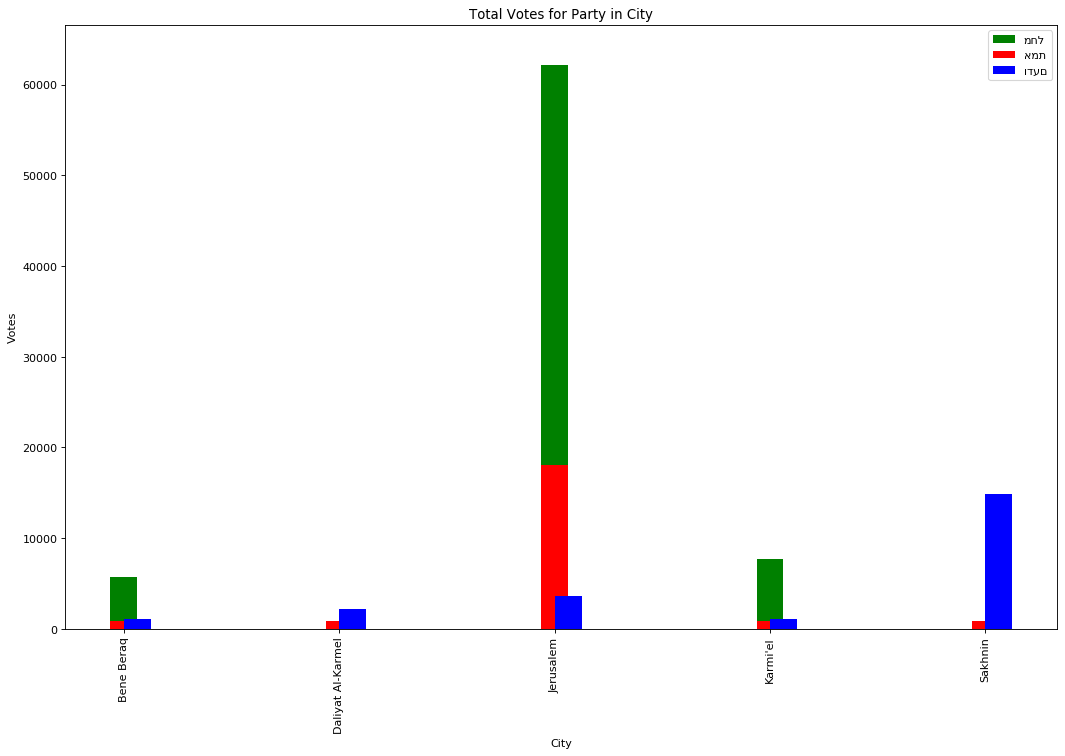

In [28]:
Y1leg = dd["מחל"]
Y2leg = dd["אמת"]
Y3leg = dd["ודעם"]

Xleg = dd.sName

plt.figure(figsize=(16,10), dpi= 80)

plt.bar(Xleg, Y1leg, color="green", width= 0.125, label = 'מחל' )
plt.bar(Xleg, Y2leg, color="red",width= 0.125, label = 'אמת' )
plt.bar(Xleg, Y3leg, color="blue", width= 0.125, label = 'ודעם', align='edge' )

gca =  plt.gca()
gca.set_ylim([0, max(df["אמת"].max(), df["אמת"].max(), df["ודעם"].max()) + 15000])
gca.set_xticklabels(Xleg, rotation=90, horizontalalignment= 'center')
plt.title("Total Votes for Party in City")
plt.xlabel('City')
plt.ylabel('Votes')
plt.legend(loc='upper right')
plt.show()